## Notebook to load and inspect output model 
the model is generated bby burernet.py 
and is saved in the file burmodel

In [1]:
import torch
import numpy as np
import os
import time
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import grad

$$
\frac{\partial u(t,x)}{\partial t} ~+~ u(t,x) \frac{\partial u(t,x)}{\partial x} ~=~ \nu \frac{\partial^2 u(t,x)}{\partial^2 x}
$$

In [2]:
import burgers
from burgers import burgers_viscous_time_exact1

vtn = 40
vxn = 40
nu = 0.01 / np.pi
xlo = -1.0
xhi = +1.0
vx = np.linspace ( xlo, xhi, vxn )

tlo = 0.0
thi = 3.0 / np.pi
thi = 1.0
vt = np.linspace ( tlo, thi, vtn )

u_true = burgers_viscous_time_exact1 ( nu, vxn, vx, vtn, vt )

In [3]:
def nth_derivative(f, wrt, n):

    for i in range(n):

        grads = grad(f, wrt, create_graph=True, allow_unused=True)[0]
        f = grads
        #print(f)
        if grads is None:
            print('bad grad')
            return torch.tensor(0.)
    return grads

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.il  = nn.Linear(2,80)
        self.mi  = nn.Linear(80,80)
        self.mi1  = nn.Linear(80,80)
        self.mi2 = nn.Linear(80,40)
        self.ol  = nn.Linear(40,1)
        #self.tn = nn.ReLU()
        self.tn  = nn.Tanh()
        #Wfor m in self.modules():
        #    if isinstance(m, nn.Linear):
        #        nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self,x,t):
        u = torch.cat((x, t), 1)
        #print(u)
        hidden1 = self.il(u)
        hidden2 = self.mi(self.tn(hidden1))
        hidden2a = self.mi1(self.tn(hidden2))
        hidden3 = self.mi2(self.tn(hidden2a))
        out =     self.ol(self.tn(hidden3))
        return out


In [5]:
def flat(x):
    m = x.shape[0]
    return [x[i] for i in range(m)]

def f(x,t):
    #u_t = grad(mynet(x,t), t, create_graph=True, allow_unused=True)[0]
    u = mynet(x,t)
    #u = [v[0], v[1]]
    u_t = nth_derivative(flat(u), wrt=t, n=1)
    u_x = nth_derivative(flat(u), wrt=x, n=1)
    #print('u_x=',u_x)
    u_xx = nth_derivative(flat(u_x), wrt=x, n=1)
    #print('u_xx=',u_xx)
    w = torch.tensor(0.01/np.pi)
    f = u_t + u*u_x - w*u_xx
    return f

In [6]:
#ivx is the set of x axis points as a tensor
#ivt is the set of t axis points as a tensor
ivx = torch.from_numpy(vx).float()
ivx =  ivx.reshape(vxn,1)
ivx.requires_grad = True

ivt = torch.from_numpy(vt).float()
ivt = ivt.reshape(vtn,1)
ivt.requires_grad = True

# we need to create the boundary conditions.  There are three segments
# when x = -1, x = 1 and t=0
#it0 is the t=0 x values
#ix1 is the x=1 is all 1s
#ixm1 is the x=-1 is all -1s
it0 = torch.zeros(vtn, dtype=torch.float, requires_grad=True).reshape(vtn,1)
ix1 = torch.zeros(vxn, dtype=torch.float, requires_grad=True).reshape(vxn,1)+1.0
ixm1  = torch.zeros(vxn, dtype=torch.float, requires_grad=True).reshape(vxn,1)-1.0
#now the values for u on the above boundary segments
xbndr = torch.from_numpy(u_true[:,0]).float() #boundary for t = 0
xbndr = xbndr.reshape(vxn,1)
ixm1t = torch.from_numpy(u_true[0,:]).float().reshape(4,10,1) #boundary u values for x = -1
ix1t  = torch.from_numpy(u_true[vxn-1,:]).float().reshape(4,10,1) #uvals for x = 1

#divide values into four batches of 10.
mt = it0.reshape(4,10,1) #this is all zeros
mx = ivx.reshape(4,10,1) #this is the full x-axis
mu = xbndr.reshape(4,10,1) #this is the u values on t=0 
#now (mx, mt, mu) is the initial condition

mt2 = ivt.reshape(4,10,1) #the t axis in four batches
mx2 = ixm1.reshape(4,10,1) #all -1s 
mx3 = ix1.reshape(4,10,1)  #all 1s
zeros  = torch.zeros(vtn, dtype=torch.float, requires_grad=True).reshape(4,10,1)

m1 = list(zip(mx, mt,mu))
m2 = list(zip(mx2[1:4], mt2[1:4], ixm1t[1:4])) #the x=-1 boundary tripple (-1,t, u(-1,t))
m3 = list(zip(mx3[1:4], mt2[1:4], ix1t[1:4]))  #the x=1 boundary tripple (1,t, u(1,t))
#note this seems to be missing the initial segments.  could be an error.
m = m1+m2+m3

bb = []
ze = zeros[0].reshape(1,10,1)
for i in range(len(ivt)):
    ts = zeros.clone()
    ts[:][:]=ivt[i]
    for j in range(4):        
        xb = mx[j].reshape(1,10,1)
        tb =ts[0].reshape(1,10,1)
        bb.append(list(zip(xb,tb,ze)))   
#bb is a list of all triplex (x, t, 0.0) for all x and t
# so it describes the interior

In [7]:
#torch.save(mynet.state_dict(), 'burgmodel')

In [52]:
mynet =  Net()
mynet.load_state_dict(torch.load('burgmodel'))

<All keys matched successfully>

In [53]:
u = mynet(ivx,it0)

(40, 1)


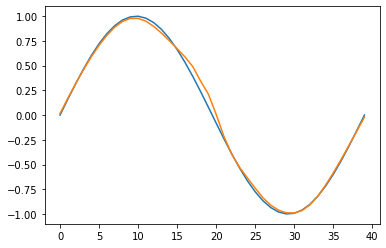

In [54]:
uu = u.detach().numpy()
print(uu.shape)
plt.plot(u_true[:,0])
plt.plot(u.detach().numpy())
#plt.plot(-np.sin(np.pi*vx))

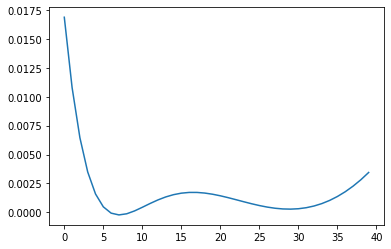

In [55]:
u = mynet(ixm1,ivt)
plt.plot(u.detach().numpy())

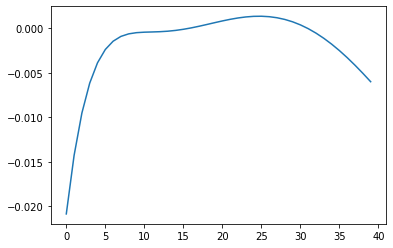

In [56]:
u = mynet(ix1,ivt)
plt.plot(u.detach().numpy())

In [57]:
x = ivx.reshape(vxn,1,1)
t = ivt.reshape(vtn,1,1)
u = np.zeros((vxn, vtn))
for i in range(0,vxn):
    for j in range(0,vtn):
        u[i][j] = mynet(x[i],t[j]).detach().numpy()

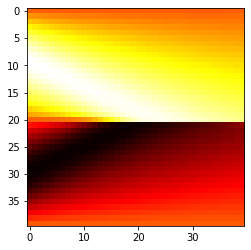

In [58]:
plt.imshow(u, cmap='hot', interpolation='nearest')

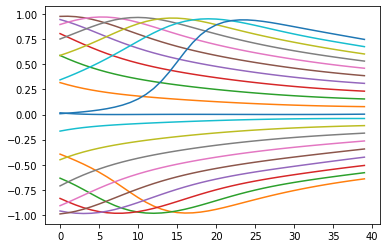

In [59]:
#plt.plot(u_true[:,0])
for i in range(0,40,2):
    plt.plot(u[i,:])

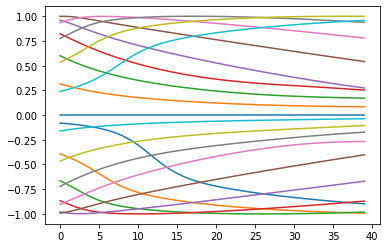

In [60]:
for i in range(0,40,2):
    plt.plot(u_true[i,:])

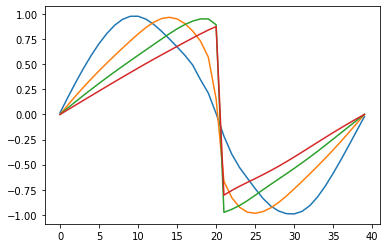

In [61]:
for i in range(0,40,10):
    plt.plot(u[:,i])

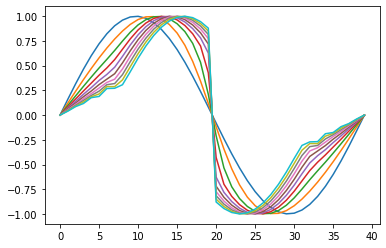

In [62]:
for i in range(0,40,4):
    plt.plot(u_true[:,i])

In [63]:
from mpl_toolkits import mplot3d


In [64]:

xarr = np.outer(np.linspace(1, -1, vxn), np.ones(vxn))

In [65]:
tarr = np.outer(np.linspace(0,40, vtn), np.ones(vtn)).T

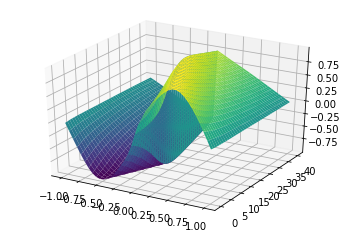

In [66]:

ax = plt.axes(projection='3d')
ax.plot_surface(xarr, tarr, u,cmap='viridis') #, edgecolor='none')

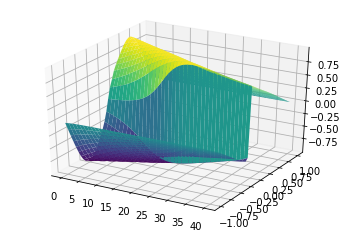

In [67]:
ax = plt.axes(projection='3d')
ax.plot_surface(tarr, xarr, u,cmap='viridis', edgecolor='none')

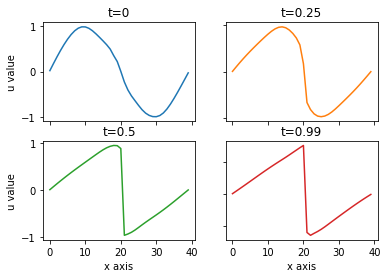

In [47]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(u[:,0])
axs[0, 0].set_title('t=0')
axs[0, 1].set_title('t=0.25')
axs[0, 1].plot(u[:,10],  'tab:orange')
axs[1, 0].set_title('t=0.5')
axs[1, 0].plot(u[:,20],  'tab:green')
axs[1, 1].set_title('t=0.99')
axs[1, 1].plot(u[:,39], 'tab:red')

for ax in axs.flat:
    ax.set(xlabel='x axis', ylabel='u value')
for ax in axs.flat:
    ax.label_outer()

$$
net(t,x):~ [0, 1.0] x [-1, 1]~  \mapsto ~ R
$$

$$
f(t,x) ~=~=\frac{\partial u(t,x)}{\partial t} ~+~ u(t,x) \frac{\partial u(t,x)}{\partial x} ~-~ \nu \frac{\partial^2 u(t,x)}{\partial^2 x}
$$

$$
bdry(t,x) ~=~ u(t,x)+sin(x/\pi) ~~ when ~ t=0 ~~ and ~~ u(t,x)=0 ~when~ x=-1~ or~ x = 1
$$

In [48]:
def f(t,x):
    u = net(t,x)
    u_t = grad(flat(u), t, create_graph=True, allow_unused=True)[0]
    u_x = grad(flat(u), x, create_graph=True, allow_unused=True)[0]
    u_xx = grad(flat(u_x), x, create_graph=True, allow_unused=True)[0]
    w = torch.tensor(0.01/np.pi)
    f = u_t + u*u_x - w*u_xx
    return f